# 可计量的社会·线性回归模型
**作者：**何濯羽

**日期：**2024年10月21日

**Python版本：**3.11.4（可使用`! python --version`检查自己的Python版本）


## 第一步：导入“包”

In [1]:
import pandas as pd                   # 数据清理
import numpy as np                    # 数学计算
import matplotlib.pyplot as plt       # 绘图
import statsmodels.api as sm          # 统计模型
import statsmodels.formula.api as smf # 统计模型便捷公式
import wooldridge as woo              # 调取 Wooldridge (2019) 书中的数据

## 第二步：导入数据

In [2]:
ceosal1 = woo.data('ceosal1')
ceosal1.head(3)

,salary,pcsalary,sales,roe,pcroe,ros,indus,finance,consprod,utility,lsalary,lsales
0,1095,20,27595.000000,14.1,106.400002,191,1,0,0,0,6.998509,10.225389
1,1001,32,9958.000000,10.9,-30.600000,13,1,0,0,0,6.908755,9.206132
2,1122,9,6125.899902,23.5,-16.299999,14,1,0,0,0,7.022868,8.720281


## 第三步：描述性统计分析

Text(0.5, 1.0, 'Histogram with density')

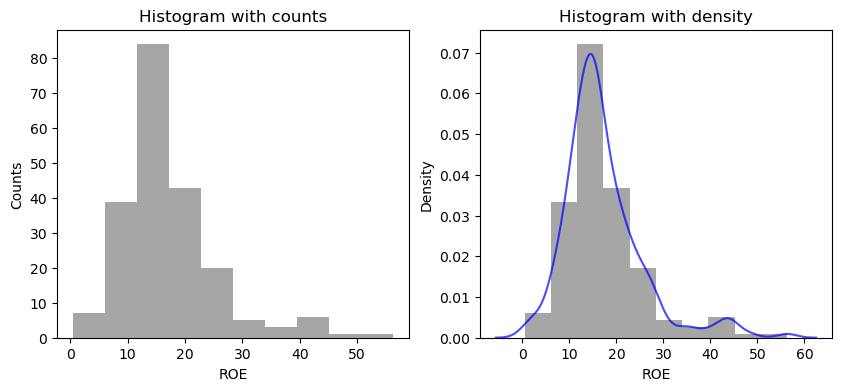

In [3]:
# 观察ROE的分布情况
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

# 图1：Histogram with counts
ax1.hist(ceosal1['roe'], color='gray', bins=10, alpha=0.7)
ax1.set_ylabel('Counts')
ax1.set_xlabel('ROE')
ax1.set_title('Histogram with counts')

# 图2：Histogram with kernel density
kde = sm.nonparametric.KDEUnivariate(ceosal1['roe'])
kde.fit()

ax2.hist(ceosal1['roe'], color='grey', alpha=0.7, density=True)
ax2.plot(kde.support, kde.density, color='blue', alpha=0.7, linewidth=1.5)
ax2.set_ylabel('Density')
ax2.set_xlabel('ROE')
ax2.set_title('Histogram with density')

Text(0.5, 1.0, 'Histogram with density')

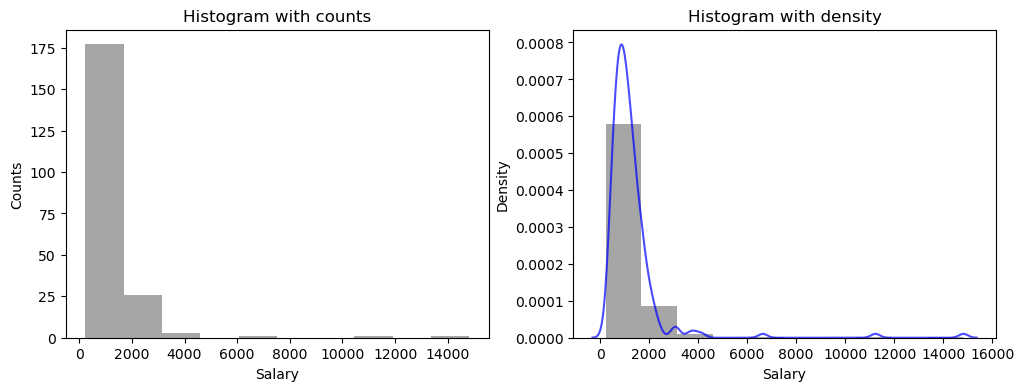

In [4]:
# 观察CEO薪资的分布情况
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

# 图1
ax1.hist(ceosal1['salary'], color='gray', alpha=0.7)
ax1.set_ylabel('Counts')
ax1.set_xlabel('Salary')
ax1.set_title('Histogram with counts')

# 图2
kde = sm.nonparametric.KDEUnivariate(ceosal1['salary'])
kde.fit()

ax2.hist(ceosal1['salary'], color='grey', alpha=0.7, density=True)
ax2.plot(kde.support, kde.density, color='blue', alpha=0.7, linewidth=1.5)
ax2.set_ylabel('Density')
ax2.set_xlabel('Salary')
ax2.set_title('Histogram with density')

## 第四步：推断性统计
我们想推断CEO的薪水（`salary`）和股东权益报酬率（`roe`）之间的关系。为此，我们可以构建如下的线性模型：

$$Y = \beta_0 + \beta_1 X + e$$

其中，$Y$表示`salary`，$X$表示`row`。我们已知：

$$\beta_1 = \frac{Cov(X,Y)}{Var(X)}, \quad \beta_0 = E(Y) - \beta_1 E(X)$$

它们的估计量是

$$\hat{\beta}_1 = \frac{\widehat{Cov}(X,Y)}{\widehat{Var}(X)}, \quad \hat{\beta}_0 = \overline{Y} - \beta_1 \overline{X}$$

接下来，让我们用如上所示的公式计算$\hat{\beta}_0$和$\hat{\beta}_1$吧！

In [5]:
x = ceosal1['roe']
y = ceosal1['salary']

# 计算样本协方差、样本方差、样本均值
cov_xy = np.cov(x, y)[1, 0]
var_x = np.var(x, ddof=1)    # ddof的默认值为0；此处我们为了得到无偏的样本方差，必须设为1
x_bar = np.mean(x)
y_bar = np.mean(y)

# 计算参数估计值
b1 = cov_xy / var_x
b0 = y_bar - b1 * x_bar

# 打印出最终数值
print('b0: {0:7.4f}'.format(b0))
print('b1: {0:7.4f}'.format(b1))

b0: 963.1913
b1: 18.5012


虽然上述的“手动”计算方法并不复杂，但它仅限于**一元线性回归模型**；当回归模型等号右侧的随机变量数量增多时，我们无法再使用以上公式快速计算参数的估计值。因此，我们需要使用更方便快捷的方法——这是计算科学家们发明统计软件的目的：为大家提供操作便捷、计算快速的工具！

In [6]:
reg = smf.ols(formula='salary ~ roe', data=ceosal1)
results = reg.fit()
b = results.params
b

Intercept    963.191336
roe           18.501186
dtype: float64

我们可以将原始数据与一元线性回归模型的估计结果同时反映在一张图上：
* 用散点展示原始数据
* 用直线展示线性回归模型的估计结果

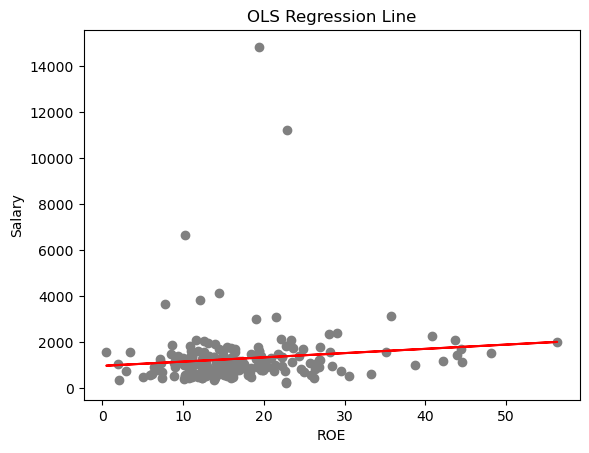

In [7]:
fig, ax = plt.subplots()

ax.scatter(ceosal1['roe'], ceosal1['salary'], color='gray')
ax.plot(ceosal1['roe'], results.fittedvalues, color='red', linestyle='-')

ax.set_ylabel('Salary')
ax.set_xlabel('ROE')
ax.set_title('OLS Regression Line')

plt.savefig('OLS_Reg_Line.svg')

### 这条红线是如何计算出来的？
上图中的红线被称为**拟合线**（fitted line），它是拟合值（fitted value）的图像化：

$$\widehat{Y} = \hat{\beta}_0 + \hat{\beta}_1 X$$

显然，拟合值$\widehat{Y}$不等于实际的观察值$Y$，它们之间的差异被称为**残差**或**残值**（residual）：

$$\hat{e} = Y - \widehat{Y} = Y - \hat{\beta}_0 - \hat{\beta}_1 X$$

如果拟合值完美地贴近观察值，那么残差为0。注意：残差为0并不是“好事”！

在以上的代码运算中，我们将线性回归模型`reg`的计算结果全部存储在了`results`这个变量中，又把`results`中的参数估计值存入了变量`b`当中。此时，`b`是一个向量——它的第一行存储着$\hat{\beta}_0$的数值，第二行存储着$\hat{\beta}_1$的数值。我们可以使用它们计算出每一个CEO的拟合值。

In [8]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     2.767
Date:                Mon, 21 Oct 2024   Prob (F-statistic):             0.0978
Time:                        22:31:23   Log-Likelihood:                -1804.5
No. Observations:                 209   AIC:                             3613.
Df Residuals:                     207   BIC:                             3620.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    963.1913    213.240      4.517      0.0

In [9]:
salary_hat = b[0] + b[1] * ceosal1['roe']
e_hat = ceosal1['salary'] - salary_hat

table = pd.DataFrame({'roe': ceosal1['roe'],
                      'salary': ceosal1['salary'],
                      'salary_hat': salary_hat,
                      'e_hat': e_hat})
table

,roe,salary,salary_hat,e_hat
0,14.1,1095,1224.058071,-129.058071
1,10.9,1001,1164.854261,-163.854261
2,23.5,1122,1397.969216,-275.969216
3,5.9,578,1072.348338,-494.348338
4,13.8,1368,1218.507712,149.492288
...,...,...,...,...
204,9.0,930,1129.702014,-199.702014
205,15.5,525,1249.959725,-724.959725
206,12.1,658,1187.055698,-529.055698
207,13.7,555,1216.657586,-661.657586


## 多元线性回归模型
$Y = \beta_0 + \beta_1 X + e$被称为“一元”线性回归模型，因为该模型只有一个自变量，即$X$。多元线性回归模型指的是具有如下所示形式的回归模型：

$$Y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_3 + \cdots + \beta_k X_k + e$$

这个模型一共有$k$个自变量，即$X_1, X_2, ..., X_k$。

在Python中，估计多元线性回归模型的参数值与估计一元模型的参数值一样方便！接下来，我们以数据`gpa1`为例，展示如何估计美国大学生的大学GPA与他们的高中GPA与ACT成绩的关系。新的回归模型如下所示：

$$\text{colGPA} = \beta_0 + \beta_1 \text{hsGPA} + \beta_2 \text{ACT} + e$$

注释：ACT的全称是American College Test。它由美国大学测评组织ACT Inc.主办, 考试内容包括数学﹑阅读﹑科学和英文四个部分，衡量高中生的学术水准及学习能力。它既是美国大学的入学条件之一，又是大学发放奖学金的主要依据之一。

In [10]:
gpa1 = woo.data('gpa1')
reg = smf.ols(formula='colGPA ~ hsGPA + ACT', data=gpa1)
results = reg.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 colGPA   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     14.78
Date:                Mon, 21 Oct 2024   Prob (F-statistic):           1.53e-06
Time:                        22:31:23   Log-Likelihood:                -46.573
No. Observations:                 141   AIC:                             99.15
Df Residuals:                     138   BIC:                             108.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2863      0.341      3.774      0.0

In [11]:
print('当ACT成绩保持不变时，高中GPA每增高1分，大学GPA的期望值增高{0:4.2f}分。'.format(results.params['hsGPA']))
print('当高中GPA保持不变时，ACT成绩每增高1分，大学GPA的期望值增高{0:4.2f}分。'.format(results.params['ACT']))

当ACT成绩保持不变时，高中GPA每增高1分，大学GPA的期望值增高0.45分。
当高中GPA保持不变时，ACT成绩每增高1分，大学GPA的期望值增高0.01分。
